In [ ]:
!wget https://cs.valdosta.edu/~rpmihail/datasets/data.zip


--2022-04-05 14:02:27--  https://cs.valdosta.edu/~rpmihail/datasets/data.zip
Resolving cs.valdosta.edu (cs.valdosta.edu)... 168.18.170.111
Connecting to cs.valdosta.edu (cs.valdosta.edu)|168.18.170.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49892991 (48M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  47.58M  26.7MB/s    in 1.8s    

2022-04-05 14:02:29 (26.7 MB/s) - ‘data.zip’ saved [49892991/49892991]



In [ ]:
!unzip -q data.zip

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


im_size = (252, 252)


# dataset definition
class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types = {'benign':0, 'malign':1}
        self.types_count = []
        for t_type in ['benign', 'malign']:
            root_dir=Path('./data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            self.types_count.append(len(files))
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
        self.sample_weights = [1/self.types_count[label] for label in self.types]
    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).find("mark")
        for x in xml_data:
            if(x.tag=='svg'):
                encoded = str(x.text)
                poly_data = json.loads(x.text)
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))[:, :, 0]
        mask = np.zeros(np.shape(im))
        im = cv2.resize(im, dsize=im_size, interpolation=cv2.INTER_CUBIC)
        
        # add mask 
        for polygon in poly_data:
            xs = []
            ys = []
            for point in polygon["points"]:
                xs.append(point["x"])
                ys.append(point["y"])
            contour = np.concatenate((np.expand_dims(xs, 1), np.expand_dims(ys, 1)), axis=1)
            cv2.fillPoly(mask, pts = [contour], color =(1, 1, 1))
        
        #mask = cv2.resize(mask, dsize=(300, 300), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, dsize=im_size, interpolation=cv2.INTER_LINEAR)
        
        
        
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)

        #plt.figure()
        #plt.imshow(im)

        transforms = Compose([ToTensor()])
        mask = transforms(mask)
        im = transforms(im)
        
        im = im * mask
        
        im = im.type(torch.FloatTensor)
        
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types, "name": str(im_name)}
        return sample

In [ ]:
# Dataset creation
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 32,
    #"shuffle": True,
}

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))

training_generator1 = torch.utils.data.DataLoader(training_set, **parameters_test, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))


testing_set = thyroidDataset(split='test')
testing_generator = torch.utils.data.DataLoader(testing_set, **parameters_test, sampler=torch.utils.data.WeightedRandomSampler(testing_set.sample_weights, len(testing_set.cases), replacement=True))


import torch.distributions

/content/data/train/benign
/content/data/train/malign
number of data items:73
/content/data/train/benign
/content/data/train/malign
number of data items:73
/content/data/test/benign
/content/data/test/malign
number of data items:25


In [ ]:

#for item in training_set:
#  print(item["labels"])


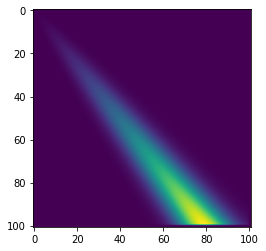

In [ ]:
from scipy.stats import dirichlet

X, Y = np.meshgrid(np.linspace(0.1, 200, 100), (np.linspace(0.1, 200, 100)))
X = np.ravel(X)
Y = np.ravel(Y)

pd = np.zeros((101, 101))


for ix in range(0, 100*100):
    x_ix, y_ix = np.unravel_index(ix, (100, 100))
    pd[x_ix, y_ix] = dirichlet.pdf(quantiles, [X[ix], 1, Y[ix]])
plt.imshow(pd)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.N = torch.distributions.Normal(0, 1)

        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0


        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=0),
            nn.ReLU(True)

        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section


        self.conditional_pipe = nn.Sequential(
            nn.Linear(2320, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )


        self.encoder_lin = nn.Sequential(
            nn.Linear(32, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        self.encoder_lin1 = nn.Sequential(
            nn.Linear(32, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        
    def forward(self, x, c):
        #print("Encoder input: ", np.shape(x))
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = torch.cat([x, c], 1).float()

        x = self.conditional_pipe(x)

        mu =  self.encoder_lin(x)
        sigma = torch.exp(self.encoder_lin1(x))


        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z
    
    
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim+16, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 3 * 3 * fc2_input_dim),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(fc2_input_dim, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(fc2_input_dim, 128, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,  padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x, labels):

        x = inputs = torch.cat([x, labels.float()], 1).float()

        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


### Define the loss function
loss_fn = torch.nn.MSELoss()
loss_latent = torch.nn.L1Loss()



### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
dim = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=dim,fc2_input_dim=512)
decoder = Decoder(encoded_space_dim=dim,fc2_input_dim=512)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=48, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4608, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(512, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(512, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [ ]:

num_epochs = 100000
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    for data in training_generator: 
        # Move tensor to the proper device
        image_batch = data["image"]
        image_batch = image_batch.to(device)

        labels = data["labels"].to(device)
        
        
        #print("Random data shape", np.shape(random_data), "; data[labels] ", np.shape(data["labels"]))
        latent = data["labels"].float()
        latent = latent.float().to(device)
        
        #print(latent)
        
        # Encode data
        encoded_data = encoder(image_batch, labels)
        
        # Decode data
        decoded_data = decoder(encoded_data, labels)
        # Evaluate loss

        #print("Encoder.kl : ", encoder.kl)

        d = ((image_batch - decoded_data)**2).sum()
        loss = d + 0.5*encoder.kl

        #loss = loss_fn(decoded_data, image_batch) + 0.2*loss_latent(encoded_data, latent.float())
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        #train_loss.append(loss.detach().cpu().numpy())   
    print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,  loss))
    diz_loss['train_loss'].append(loss)


 EPOCH 1/100000 	 train loss 758.5679931640625

 EPOCH 2/100000 	 train loss 881.258544921875

 EPOCH 3/100000 	 train loss 701.7865600585938

 EPOCH 4/100000 	 train loss 592.6571044921875

 EPOCH 5/100000 	 train loss 643.5368041992188

 EPOCH 6/100000 	 train loss 973.4163208007812

 EPOCH 7/100000 	 train loss 772.0691528320312

 EPOCH 8/100000 	 train loss 704.6163940429688

 EPOCH 9/100000 	 train loss 665.9541625976562

 EPOCH 10/100000 	 train loss 1015.0863037109375

 EPOCH 11/100000 	 train loss 770.0333862304688

 EPOCH 12/100000 	 train loss 541.7216796875

 EPOCH 13/100000 	 train loss 686.0645751953125

 EPOCH 14/100000 	 train loss 515.4102783203125

 EPOCH 15/100000 	 train loss 738.325439453125

 EPOCH 16/100000 	 train loss 627.6050415039062

 EPOCH 17/100000 	 train loss 628.7476806640625

 EPOCH 18/100000 	 train loss 741.2515869140625

 EPOCH 19/100000 	 train loss 889.5162963867188

 EPOCH 20/100000 	 train loss 913.3349609375

 EPOCH 21/100000 	 train loss 524.7

KeyboardInterrupt: ignored

torch.Size([32, 32])


RuntimeError: ignored

In [ ]:
d

tensor(791.7478, device='cuda:0', grad_fn=<SumBackward0>)

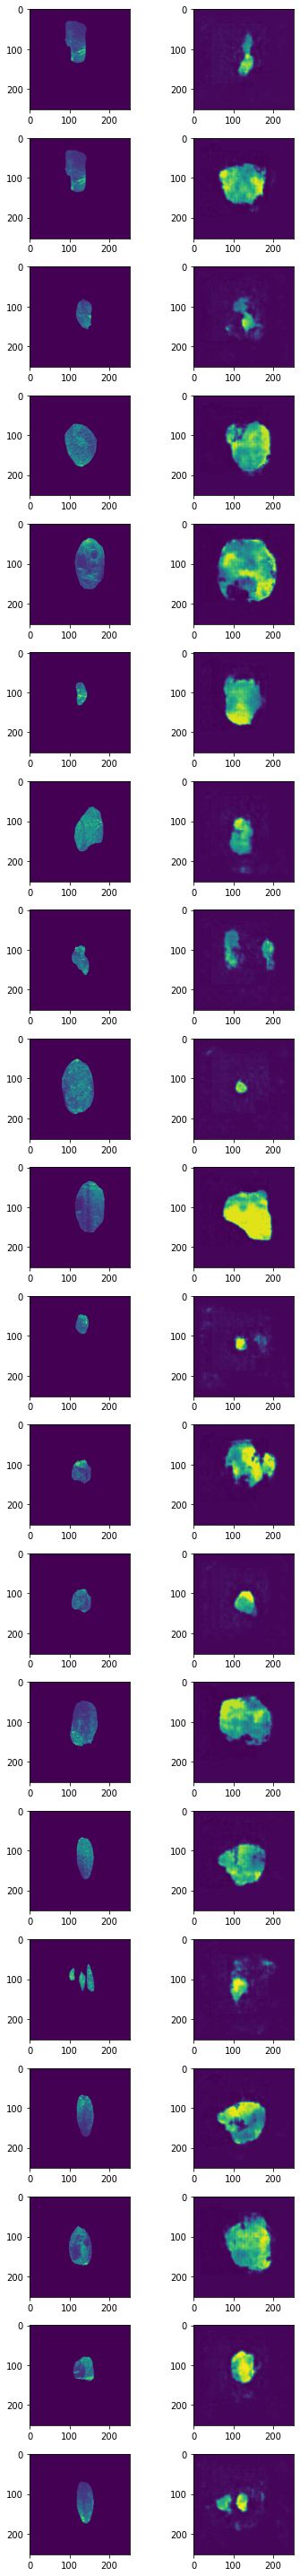

In [ ]:
fig, ax = plt.subplots(20, 2, figsize=(10, 40))
fig.set_tight_layout(True)

c = 0
for data in testing_generator: # with "_" we just ignore the labels (the second element of the dataloader tuple)
    # Move tensor to the proper device
    
    labels = data["labels"].float().to(device)
    
    if(c>=20):
        break
    image_batch = data["image"]


    #print("Random data shape", np.shape(random_data), "; data[labels] ", np.shape(data["labels"]))
    latent = torch.FloatTensor(np.random.randn(1,dim)).to(device)
   
    
    img_recon = decoder(latent, labels)

    img_recon = img_recon.detach().cpu().numpy()
    
    ax[c, 0].imshow(image_batch[0, 0, :, :])
    ax[c, 1].imshow(img_recon[0, 0, :, :])
    
    c += 1
    

plt.tight_layout()
    
    

In [ ]:
print(torch.__version__)